In [2]:
import pandas as pd
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.constraints import maxnorm
from matplotlib import pyplot
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import datetime

Using TensorFlow backend.


In [3]:
X_train = pd.read_csv("X_train.csv")
X_train = X_train.iloc[:, 1:]
X_test = pd.read_csv("X_test.csv")
X_test = X_test.iloc[:, 1:]
Y_train = pd.read_csv("y_train.csv")
Y_test = pd.read_csv("y_test.csv")
Y_train = Y_train['Rating as Factor'].astype('category') #factorize trainset
Y_test = Y_test['Rating as Factor'].astype('category')   #factorize testset
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train) #standardizing using StandardScaler
X_test_std = scaler.transform(X_test) #standardizing using StandardScaler

In [8]:
def baseline_model1(optimizer='Nadam',neurons=350,activ='sigmoid',dropout_rate=0.0):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=36, activation=activ))
    model.add(Dropout(dropout_rate))
    model.add(Dense(17, activation='softmax'))
    # compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #This loss function doesn't need OneHotEncoded Y-Variables.
    return(model)

def baseline_model2(optimizer='Nadam',neurons1=400,neurons2=150,activ1 = 'sigmoid', activ2 = 'sigmoid', dropout_rate1=0.0,dropout_rate2=0.0):
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=36, activation=activ1))
    model.add(Dropout(dropout_rate1))
    model.add(Dense(neurons2, activation=activ2))
    model.add(Dropout(dropout_rate2))
    model.add(Dense(17, activation='softmax'))
    # compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #This loss function doesn't need OneHotEncoded Y-Variables.
    return(model)


def NeuralNet1layer(X_train_std,Y_train, param_grid):
    model = KerasClassifier(build_fn=baseline_model1, epochs=100, batch_size=20,verbose=0)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1) #We don't use a pipeline because of the limits of Keras sklearn wrapper which can't do a gridsearch over the hyperparameters when in a pipeline, also for some hyperparameters parallelizing is not possible due to the wrapper
    grid_result = grid.fit(X_train_std, Y_train)
    return(grid_result)

def NeuralNet2layer(X_train_std,Y_train, param_grid):
    model = KerasClassifier(build_fn=baseline_model2, epochs=100, batch_size=20,verbose=0)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1) #We don't use a pipeline because of the limits of Keras sklearn wrapper which can't do a gridsearch over the hyperparameters when in a pipeline
    grid_result = grid.fit(X_train_std, Y_train)
    return(grid_result)


In [4]:


#The best Grid Search would be to test all hyperparameter configurations simultaneously because of possible interactions of the hyperparameters. 
#However this would take an extremely long time due to the many hyperparameters and their possible values.
#Therefore we take a sequential approach(1 or 2 hyperparameters at a time) on grid searching the hyperparameters to not have to train the model over multiple days.



# define the grid search hyperparameters:
# after 100 epochs the accuracy doesn't improve much therefore we use epoch=100 in order to have a well trained neural net which doesn't need too much time to fit.

#batch_size = [5,10,20] yields that 5 is the best hyperparameter. It makes sense that a lower batch size results in a better accuracy since it optimizes more often. 
#A lower batch size means we more often adjust the weights which takes time. 
#The differnces between the batch size accuracy is only 1% while the time for computing is significantly lower for higher batch sizes. 
#Therefore for finding the other optimal hyperparameters we use a batch size of 20 and might adjust it for the final model fitting with the optimal hyperparameters

#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'] yielded Nadam to be the best optimizer with Adam on second rank.
#Nadam is is Adam with Nesterov Momentum as they both take the same amount of time to train we'll use Nadam because of its better accuracy.

#1Layer: Best combination of each activation for neurons in grid[150,200,250,300]: 
#0.893909 (0.010722) with: {'activ': 'relu', 'neurons': 300}
#0.937349 (0.001372) with: {'activ': 'tanh', 'neurons': 250}
#0.933268 (0.000530) with: {'activ': 'sigmoid', 'neurons': 250
#0.897989 (0.006316) with: {'activ': 'hard_sigmoid', 'neurons': 300}
#0.767458 (0.032144) with: {'activ': 'softmax', 'neurons': 300}
#0.846942 (0.002463) with: {'activ': 'softplus', 'neurons': 300}
#0.935521 (0.003249) with: {'activ': 'softsign', 'neurons': 250}
#0.315170 (0.006817) with: {'activ': 'linear', 'neurons': 300}
#-> Test the Top3 activation functions for 200 epochs with neurons grid[200,250,300,350] in hopes that maybe after 200epochs one activation function will be clearly better:
#Best is 0.947295 (0.000936) with: {'activ': 'sigmoid', 'neurons': 350} (1%better than other activation functions)

#Checking dropoutrate together with weight constraint we get a dropout rate of 0.0 and a high weight constraint as best hyperparameters.
#This means regularization here does not help and we don't use dropouts or weight constraints.


#2Layers: Test combinations of neurons in each layer with different activation functions.
#We only included softsign, relu and sigmoid as the possible activation function. This because sigmoid&softsign performed very well on 1layer and relu seems to be favoured by a lot of people in the literature.
#We didn't include tanh because it seems to work very similar to the sigmoid acivation function. We didn't include more activation function to keep the time for the grid search in a somewhat acceptable range.
#Grid Search found this as the best combination: Best: 0.943087 using {'activ1': 'sigmoid', 'activ2': 'sigmoid', 'neurons1': 400, 'neurons2': 150}

#Again dropout Rate is chosen as 0.0 being the best combination.



In [7]:
#1Layer Neural Net(According to the Universal Approximation Theorem theoretically a 1 Layer Neural Net can approximate any other Neural Network):
#Final model after Hyperparameter optimization. We get a 96% accuracy for the testset
dropout_rate = [0.0]
optimizer = ['Nadam']
activ = ['sigmoid']
neurons = [350,400,450]
epochs=[200]
batch_size=[10]
print(datetime.datetime.now())
# model fitting

param_grid = dict(dropout_rate=dropout_rate, optimizer=optimizer,activ=activ,neurons=neurons,epochs=epochs,batch_size=batch_size)
grid = NeuralNet1layer(X_train_std,Y_train,param_grid)
#results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print('Test score:', grid.score(X_test_std,Y_test)) 
y_pred = grid.predict(X_test_std)
# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': Y_test})
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 
print(datetime.datetime.now())

2020-04-14 20:39:22.245265
Best: 0.945807 using {'activ': 'sigmoid', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 200, 'neurons': 350, 'optimizer': 'Nadam'}
0.945807 (0.001247) with: {'activ': 'sigmoid', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 200, 'neurons': 350, 'optimizer': 'Nadam'}
0.941089 (0.000357) with: {'activ': 'sigmoid', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 200, 'neurons': 400, 'optimizer': 'Nadam'}
0.941556 (0.002023) with: {'activ': 'sigmoid', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 200, 'neurons': 450, 'optimizer': 'Nadam'}
Test score: 0.9642978310585022
Predicted   0    1    2   3     4    5   6    7    8   9   10  11  12   13  \
True                                                                         
0          719    7    0   0     0    1   0    2    1   0   0   0   0    1   
1            3  379    5   0     0    0   1    1    0   0   0   0   0    0   
2            1    6  188   0     1    0   0    1    0   1   0   0   0    0   
3

Train: 0.992, Test: 0.966


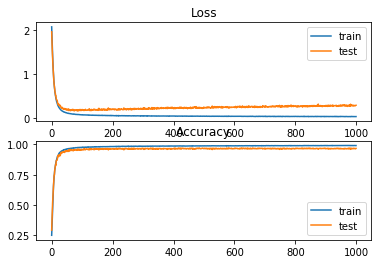

In [10]:
#Training the optimal Neural Network with 1 Layer on the whole Training Data
model = Sequential()
model.add(Dense(350, input_dim=36, activation='sigmoid'))
model.add(Dense(17, activation='softmax'))
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
# fit model
history = model.fit(X_train_std, Y_train, validation_data=(X_test_std, Y_test), epochs=200, batch_size=10, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(X_train_std, Y_train, verbose=0)
_, test_acc = model.evaluate(X_test_std, Y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


In [7]:
#2Layer Neural Net:
activ1 = ['sigmoid']
activ2 = ['sigmoid']
neurons1 = [400]
neurons2 = [150]
dropout_rate1 = [0.0]
dropout_rate2 = [0.0]
print(datetime.datetime.now())
# model fitting

param_grid = dict(activ1=activ1,activ2=activ2,neurons1=neurons1,neurons2=neurons2,dropout_rate1=dropout_rate1,dropout_rate2=dropout_rate2)
grid = NeuralNet2layer(X_train_std,Y_train,param_grid)
#results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print('Test score:', grid.score(X_test_std,Y_test)) 
y_pred = grid.predict(X_test_std)
# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': Y_test})
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 
print(datetime.datetime.now())

2020-04-14 17:35:48.312042
Best: 0.943937 using {'activ1': 'sigmoid', 'activ2': 'sigmoid', 'dropout_rate1': 0.0, 'dropout_rate2': 0.0, 'neurons1': 400, 'neurons2': 150}
0.943937 (0.001614) with: {'activ1': 'sigmoid', 'activ2': 'sigmoid', 'dropout_rate1': 0.0, 'dropout_rate2': 0.0, 'neurons1': 400, 'neurons2': 150}
Test score: 0.9622577428817749
Predicted   0    1    2   3     4    5   6    7    8   9   10  11  12   13  \
True                                                                         
0          719    3    0   0     0    0   0    8    0   0   0   0   0    1   
1            5  373    9   0     0    0   1    1    0   0   0   0   0    0   
2            1    4  193   0     0    0   0    0    0   0   0   0   0    0   
3            0    0    0  59     0    0   0    0    0   0   0   0   0    0   
4            2    1    1   0  1050   15   0    1   18   0   0   0   0    0   
5            0    0    0   0    20  609   0    0    6   0   0   0   0    0   
6            0    1    3   1 

Train: 0.990, Test: 0.967


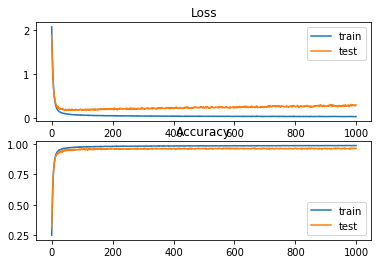

In [9]:
model = Sequential()
model.add(Dense(400, input_dim=36, activation='sigmoid'))
model.add(Dense(150, activation='sigmoid'))
model.add(Dense(17, activation='softmax'))
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
# fit model
history = model.fit(X_train_std, Y_train, validation_data=(X_test_std, Y_test), epochs=200, batch_size=20, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(X_train_std, Y_train, verbose=0)
_, test_acc = model.evaluate(X_test_std, Y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()